<a href="https://colab.research.google.com/github/lych0508/Projects/blob/main/DemandForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview

In this project, I will use historical data and external signals to develop a model to help a pharmacy store chain with the future demand on different nutrition related products

In [1]:
import pandas as pd
import sklearn.metrics
import sklearn
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import joblib
import lightgbm as lgbm

# Load data

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Load sales data
link = 'https://drive.google.com/open?id=13EzwOKMtF24uTcF6DC8YbTv9lrRSksTN'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('Historical_sales2.csv')  
# Read file as panda dataframe
train = pd.read_csv('Historical_sales2.csv')

In [4]:
#Load product data
link = 'https://drive.google.com/open?id=14-KnpZQQHoA67r3e77astmJhmHG83aDi'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('Product2.csv')  
# Read file as panda dataframe
train = pd.read_csv('Product2.csv')

In [5]:
#Load predict data
link = 'https://drive.google.com/open?id=1CeNT1qn5UmquaM6deJ65HlWKbV46lA_1'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('Predicted_list2.csv')  
# Read file as panda dataframe
train = pd.read_csv('Predicted_list2.csv')

In [6]:
#Load data as dataframe
sales_df = pd.read_csv('Historical_sales2.csv')
# reserve_df = pd.read_csv('Pre_reservation.csv')
product_df = pd.read_csv('Product2.csv')
predict_df = pd.read_csv('Predicted_list2.csv')

# 1. Data Pre-possessing
* Historical_sales is the weekly historical sales data for each product from Spring 2014 to Spring 2016
* Products contains the product information
* To_predict has the products that need demand forecasting at quarterly level


In [7]:
# check for format
sales_df.head(2)

,transaction_date,sku,location,quarter,sales_amt,shelf_amt
0,1/18/14,3660,GERMANY,SP2014,51,578
1,9/12/15,6159,GERMANY,FA2015,1,89


In [8]:
product_df.head(2)

,sku,brand,age,formation,family,sales_price,specs
0,6336,L273,ADULT,capsule,Omega3FattyAcid,138,PATENT 5726
1,8821,G633,GRADE SCHOOL,liquid,VitaminC,42,PATENT 6776|PATENT 4090|PATENT 5726


In [9]:
predict_df.head(2)

,sku,quarter
0,8852,SU2016
1,3403,SU2016


In [10]:
print ('Number of rows in sales_df: ' + str(sales_df.shape[0]))
print ('Number of columns sales_df: ' + str(sales_df.shape[1]))

print ('Number of rows in product_df: ' + str(product_df.shape[0]))
print ('Number of columns product_df: ' + str(product_df.shape[1]))

print ('Number of rows in predict_df: ' + str(predict_df.shape[0]))
print ('Number of columns predict_df: ' + str(predict_df.shape[1]))

Number of rows in sales_df: 186836
Number of columns sales_df: 6
Number of rows in product_df: 407
Number of columns product_df: 7
Number of rows in predict_df: 407
Number of columns predict_df: 2


In [11]:
# check Null value and duplicates
for i in [sales_df,product_df,predict_df]:
    print (i.isnull().sum())
    print (i.duplicated().sum())

transaction_date    0
sku                 0
location            0
quarter             0
sales_amt           0
shelf_amt           0
dtype: int64
1808
sku            0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64
0
sku        0
quarter    0
dtype: int64
0


## 1.1 Carry_over product vs. new product
Note: product is defined by *sku* as instructed

* carry_over product: products having a historical data (320)
* new product: products not having historical data (87)


In [12]:
# mask carry-over and new products in predict_df
mask_co = predict_df['sku'].isin(sales_df['sku'])
mask_new = ~mask_co

# predict_df and product_df have the same group of sku in this project

# get the new products and previous carry-over products
print ('# carry-over products:', mask_co.sum())
print ('# new productds:', mask_new.sum())

# carry-over products: 320
# new productds: 87


## 1.2 Join tables
* Join sales_df with product_df. **left join: only carry-over products**
* *new_product* contains the product information of only new products

In [13]:
# aggregate pos from weekly to quarterly
function1 = {'sales_amt':'sum', 'shelf_amt':'sum'}
sales_quarterly = sales_df.groupby(['sku','location','quarter'], as_index = False).agg(function1)

In [14]:
# merge pos, booking, and style into one table for carry-over
co_combine = sales_quarterly.merge(product_df,on=['sku'],how='left')
print (co_combine.isnull().sum())

# get product info of new product (sales data not available)
new_product = product_df[~predict_df['sku'].isin(sales_df['sku'])]

sku            0
location       0
quarter        0
sales_amt      0
shelf_amt      0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64


 **What to do if you have missing values? **



*   2% missing - delete 
*   10% missing - 

> Simple approach: using average value, but this lacks the insights of distribution of missing values

> Alternative approach: using a regression/classification model to predict and fill the missing values - chosen

*   50% missing - join table doesn't make sense




In [15]:
co_combine.head(2)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030


In [16]:
#check data type
co_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6942 entries, 0 to 6941
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          6942 non-null   int64 
 1   location     6942 non-null   object
 2   quarter      6942 non-null   object
 3   sales_amt    6942 non-null   int64 
 4   shelf_amt    6942 non-null   int64 
 5   brand        6942 non-null   object
 6   age          6942 non-null   object
 7   formation    6942 non-null   object
 8   family       6942 non-null   object
 9   sales_price  6942 non-null   int64 
 10  specs        6942 non-null   object
dtypes: int64(4), object(7)
memory usage: 650.8+ KB


In [17]:
#check extreme values
co_combine.describe()

,sku,sales_amt,shelf_amt,sales_price
count,6942.000000,6942.000000,6.942000e+03,6942.000000
mean,5340.072025,6281.764477,1.022155e+05,88.376693
std,2829.511463,23467.389865,3.478001e+05,49.898150
min,12.000000,0.000000,0.000000e+00,13.000000
25%,3149.000000,14.000000,1.705000e+02,53.000000
50%,5153.000000,247.000000,3.794500e+03,77.000000
75%,7798.000000,2714.250000,4.453200e+04,111.000000
max,9974.000000,394983.000000,5.513126e+06,306.000000


# 2. Exploratory data analyses (EDA)

## 2.1. Correlation analyses
* plot linear correlation among the features
* *sales_amt* is the target metric and not included

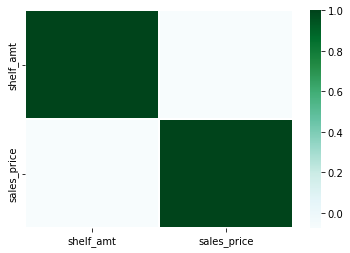

In [18]:
# numerical correlation
num_corr = co_combine[['shelf_amt','sales_price']].corr(method ='pearson')
sns.heatmap(num_corr, cmap="BuGn", linewidths=0.5)

There is not too much relationship between numerical features

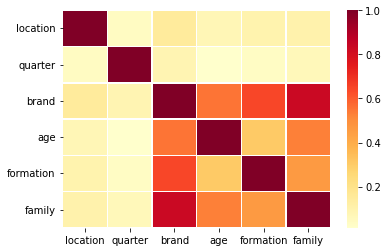

In [19]:
# categorical list without specs
tmp_1 = ['location','quarter','brand','age','formation','family']
# correlation of the categorical features 
df_1 = co_combine[tmp_1]
chi_square = pd.DataFrame(abs(np.random.randn(len(tmp_1),len(tmp_1))), columns= tmp_1, index = tmp_1)

# cramer V statistics for correlation between categorical features
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# chi square dataframe of categorical features
for i in tmp_1:
    temp_list = [k for k in tmp_1 if k!=i]
    for j in temp_list:
        confusion_matrix = pd.crosstab(df_1[i],df_1[j])
        val = cramers_corrected_stat(confusion_matrix)
        chi_square[i][j] = float(val) # column, row
        chi_square[i][i] = 1
        
# heatmap of categorical features (exclude the complex string)
sns.heatmap(chi_square, cmap='YlOrRd', linewidths=0.5)

There are some correlations between some features. For example family and brand, age and brand.

## 2.2. Glance at columns


### 2.2.1 Numerical data

In [20]:
# plot histogram with accumulative curve
def plot_hist_cum(df, column_name, title, right_range, hist_color, logscale):
    fig, ax1 = plt.subplots()
    ax1.hist(df[column_name].values, range(0,right_range), color = hist_color, 
             alpha = 0.7,density =False, log=logscale)
    ax1.tick_params(labelcolor=hist_color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.hist(df[column_name].values, range(0,right_range), histtype='step', color = 'grey', density = True, 
         cumulative = 1, lw = 2)
    ax2.tick_params(labelcolor='grey')
    ax1.set_ylabel('Likelihood of occurrence')
    plt.title(title)
    plt.show()

In [21]:
co_combine[['sales_amt','shelf_amt','sales_price']].describe(percentiles = [.25, .5, .75, .95])

,sales_amt,shelf_amt,sales_price
count,6942.000000,6.942000e+03,6942.000000
mean,6281.764477,1.022155e+05,88.376693
std,23467.389865,3.478001e+05,49.898150
min,0.000000,0.000000e+00,13.000000
25%,14.000000,1.705000e+02,53.000000
50%,247.000000,3.794500e+03,77.000000
75%,2714.250000,4.453200e+04,111.000000
95%,28323.800000,4.943733e+05,175.000000
max,394983.000000,5.513126e+06,306.000000


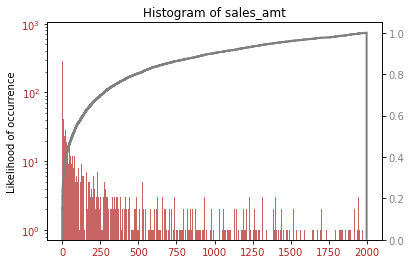

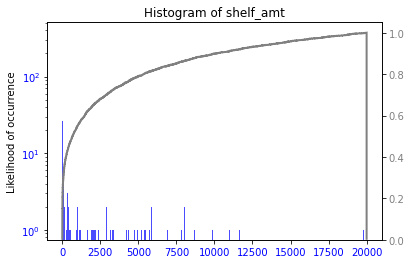

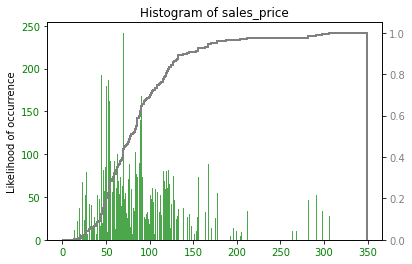

In [22]:
plot_hist_cum(co_combine, 'sales_amt', 'Histogram of sales_amt',2000,'firebrick', True)
plot_hist_cum(co_combine, 'shelf_amt', 'Histogram of shelf_amt',20000,'blue', True)
plot_hist_cum(co_combine, 'sales_price', 'Histogram of sales_price',350,'green', False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


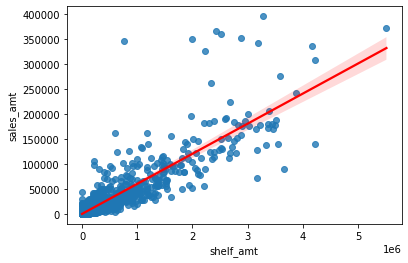

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


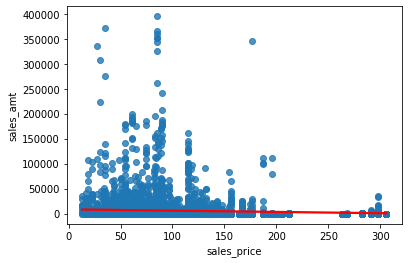

In [23]:
# plot linear dependency between the numberical and target 
for i in ['shelf_amt','sales_price']:
    sns.regplot(i,'sales_amt', data=co_combine,
               line_kws = {'color':'red'}, label = i)
    plt.show()

In the regression overview, there are some positive relationship between sales amount and shelf amount. On the other hand, there is no significant relationship between sales price and sales amount. 

### 2.2.2 Categorical data
* count of each category
* correlation between categorical feature with sales

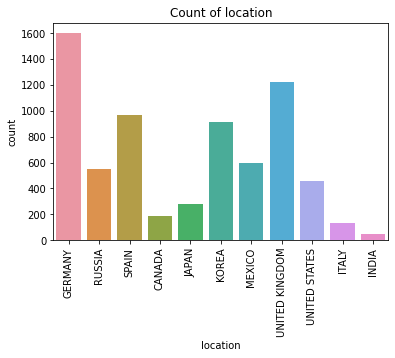

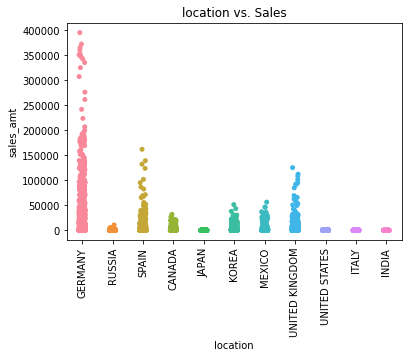

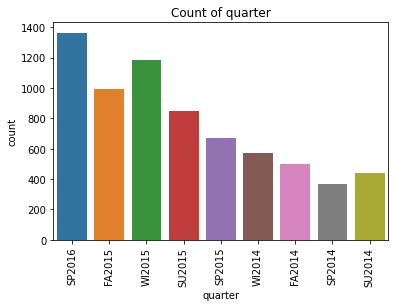

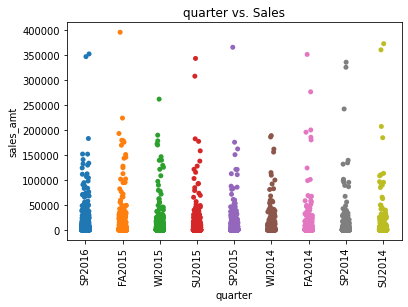

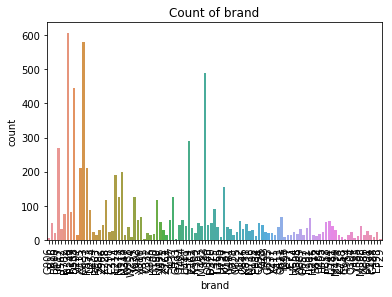

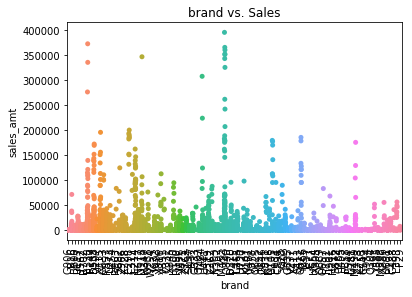

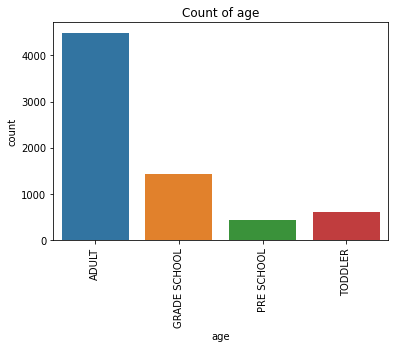

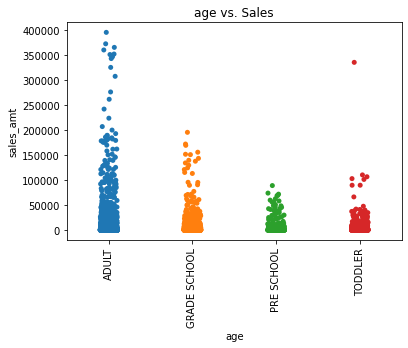

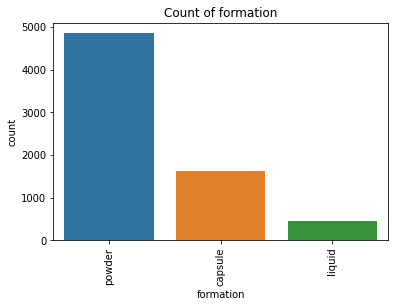

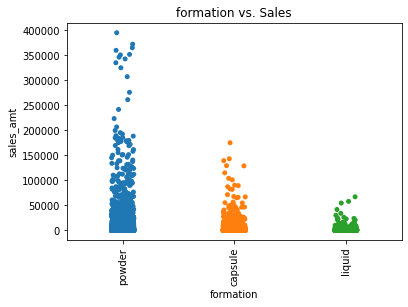

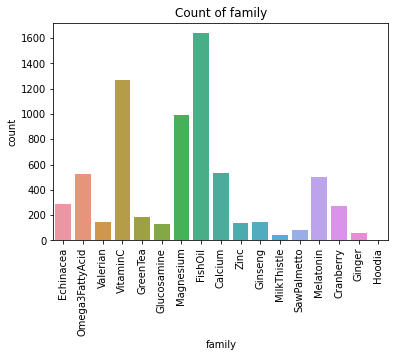

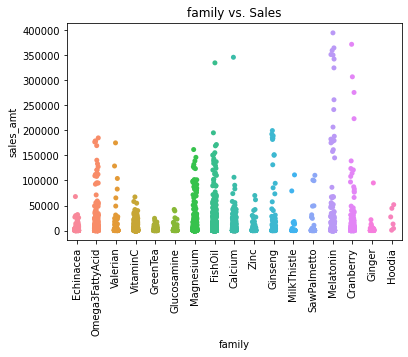

In [24]:
for i in ['location','quarter','brand','age','formation','family']:
    sns.countplot(x=i, data=co_combine)
    plt.xticks(rotation=90)
    plt.title('Count of {}'.format(i))
    plt.show()
    sns.stripplot(x=i, y='sales_amt', data=co_combine, jitter=True)
    plt.xticks(rotation=90)
    plt.title('{} vs. Sales'.format(i))
    plt.show()


# 3. Feature processing



## 3.1 Extra features
* Extra Season and Year out of quarter
* Count # patents in a product

In [25]:
# extract season
co_combine_1 = co_combine.copy(deep =True)
co_combine_1['season'] = co_combine_1['quarter'].astype(str).str[0:2]
co_combine_1['year'] = co_combine_1['quarter'].astype(str).str[2:7]
# co_combine_1.drop(['quarter'], axis =1, inplace=True)
# get numnber of technology, color_family, design_code of each product
num_specs = co_combine_1['specs'].str.split('|').str.len()
co_combine_1['num_specs'] = num_specs


# treat 'specs' in new products as well
new_product_1 = new_product.copy(deep =True)
num_specs_new = new_product_1['specs'].str.split('|').str.len()
new_product_1['num_specs'] = num_specs_new

In [26]:
num_specs_new.head()

5     3
8     1
11    1
23    1
30    1
Name: specs, dtype: int64

## 3.2 Bucktize and scaling
* bucktize *sales_price*
* scale numerical features

In [27]:
# bin MSRP_Amt and convert into dummies
price = [1,30,60,80,100,180,450]
price_range = ['<=$30','$30-60','$60-80','$80-100','$100-180','>$180']
price_bin = pd.cut(co_combine_1['sales_price'], price, labels=price_range)
price_seg = pd.get_dummies(price_bin).astype(np.int64)

# carry-over
co_combine_1.drop(['sales_price'], axis =1, inplace=True)
co_combine_1 = pd.concat([co_combine_1, price_seg], axis=1)

# new
price_bin_new = pd.cut(new_product_1['sales_price'], price, labels=price_range)
price_seg_new = pd.get_dummies(price_bin_new).astype(np.int64)
new_product_1.drop(['sales_price'], axis =1, inplace=True)
new_product_1 = pd.concat([new_product_1, price_seg_new], axis=1)

In [28]:
# robust scaling
co_combine_2 = co_combine_1.copy(deep=True)
scale_lst = ['shelf_amt','num_specs']
rs_scale = preprocessing.RobustScaler().fit(co_combine_2[scale_lst])
co_combine_2[scale_lst] = rs_scale.transform(co_combine_2[scale_lst])

# 4. Modeling
* Two models will be developed: one for carry-over products; one for new products
* The carry over model will be training on only its own historical data
* The new model will be training on the data based on similarity with the new products

## 4.1. Carry-over product model
* Use data of each product to build numerous models is not ideal, the average data point of each product/sku is 22, it is too little to build a good model
* Traditional method such as ARIMA could be used, but it lacks the 'insight' of products inner corrleation. Each product is independent
* Build a complicated model using more products is a better option
* Target metric y = *sales_amt*
* SP2016 data is used to evaluate the model

### 4.1.1 Dummy features and train/test split

In [29]:
cate_list = ['location','brand','age','formation','family','specs',
             'season','year']
co_combine_2 = pd.get_dummies(co_combine_2,columns=cate_list,drop_first=True) 

In [30]:
# select ~20% latest data for test purpose
co_combine_2_test = co_combine_2[co_combine_2['quarter'] =='SP2016']
co_combine_2_train = co_combine_2[co_combine_2['quarter'] !='SP2016']

In [31]:
# prepare training and test data
co_combine_2_train = shuffle(co_combine_2_train)
co_combine_2_train_X = co_combine_2_train.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_2_train_y = co_combine_2_train['sales_amt'] 

co_combine_2_test_X = co_combine_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_2_test_y = co_combine_2_test['sales_amt'] 

### 4.1.2  Quick linear model for baseline
* Use Lasso regression for quick baseline
* Mean absolute percentage error (MAPE), mean absolute error (MAE), and the ratio Mean absolute deviation (MAD) are used as evaluation metric

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.832e+08, tolerance: 3.218e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


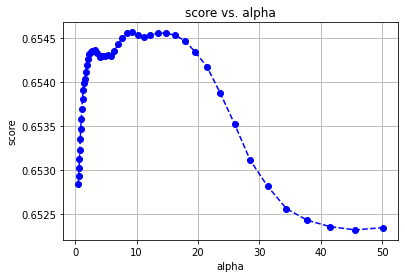

The optimaized alpha and score of Lasso linear is:  9.232219520747307 0.6545664092620482


In [32]:
# Lasso model
alphas = np.logspace (-0.3, 1.7, num=50)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(co_combine_2_train_X, co_combine_2_train_y)
    scores[i] = lasso.score(co_combine_2_test_X, co_combine_2_test_y)
    if scores[i] > max_score: # lasso.score is r2 
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

In [33]:
# use  optimal alpha, re-train the model
lasso_f = Lasso(alpha = opt_a)
lasso_f.fit(co_combine_2_train_X, co_combine_2_train_y)
lasso_pred = lasso_f.predict(co_combine_2_test_X)

In [34]:
# compare the aggreated prediction with actual sales
co_test_lasso = co_combine_2_test.copy(deep=True)
co_test_lasso['pred'] = np.round(lasso_pred)
co_test_lasso['pred'] = co_test_lasso['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
co_test_lasso_agg = co_test_lasso.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

In [35]:
# define MAPE and MAD_ratio, and evalution result
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+1)))*100

def mean_absolute_deviation_ratio(y_true, y_pred):
    return y_pred.mad()/(y_true.mad()+0.1)

def evaluate(result_agg):
    MAPE = mean_absolute_percentage_error(result_agg['sales_amt'],result_agg['pred'])
    print ('MAPE of prediction in SP2016 is {}'.format(MAPE))  #MAPE
    MAE = mean_absolute_error(result_agg['sales_amt'], result_agg['pred'])
    print ('MAE of prediction in SP2016 is {}'.format(MAE))   # MAE
    MAD_ratio = mean_absolute_deviation_ratio(result_agg['sales_amt'],result_agg['pred'])
    print ('MAD ratio of prediction in SP2016 is {}'.format(MAD_ratio))
    # MAD ratio
    
def plot_diff(result_agg, title1, title2):    # plot the pred vs. actual
    plt.plot(result_agg['pred'],'o', color='red', alpha=0.3)
    plt.plot(result_agg['sales_amt'],'*', color='blue', alpha=0.5)
    plt.title(title1)
    plt.legend(loc='upper right')
    plt.show()

    plt.plot((result_agg['pred'] - result_agg['sales_amt'])
             ,'v', color='green')
    plt.title(title2)
    plt.show()

In [36]:
evaluate(co_test_lasso_agg)

MAPE of prediction in SP2016 is 1537.6025751855354
MAE of prediction in SP2016 is 10404.313479623825
MAD ratio of prediction in SP2016 is 1.0221017163270145


No handles with labels found to put in legend.


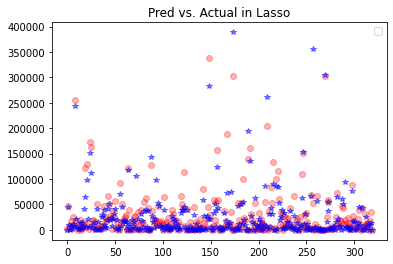

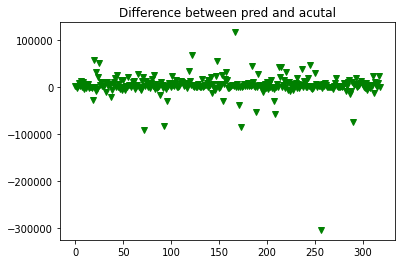

In [37]:
plot_diff(co_test_lasso_agg, 'Pred vs. Actual in Lasso', 'Difference between pred and acutal')

### 4.1.3 Random forest model

In [38]:
# plot the hyper-parameter tuning
def class_plot(grid, grid_param, title):
    scores = [x for x in grid.cv_results_['mean_test_score']]
    m_depth = grid_param['max_depth']
    n_est = grid_param['n_estimators']
    scores = np.array(scores).reshape(len(m_depth), len(n_est))
    fig = plt.figure()
    ax = plt.subplot(111)
    for ind, i in enumerate(m_depth):
        plt.plot(n_est, scores[ind], '-o', label='Max depth' + str(i),)
    ax.legend(loc='lower right') #, bbox_to_anchor=(1, 0.5))
    plt.xlabel('n estimator')
    plt.ylabel('Mean score')
    plt.title(title)
    plt.show()
    

# get the raw features importance (aggregate all dummies)
def raw_feature_importance(importance_dataframe, num_pos, cate_list):
    # numercial feature importance
    num_importance = importance_dataframe.head(num_pos) 
    num_importance.reset_index(drop = True, inplace = True)

    cate_dict ={}
    for i in cate_list:
        summ = 0
        for (idx, row) in importance_dataframe.iterrows():
            if i in row.loc['Feature']:
                summ += row.loc['Importance']
        cate_dict[i] = summ 
    
    cate_importance = pd.DataFrame.from_dict(cate_dict, orient='index')
    cate_importance.rename(columns={0: 'Importance'}, inplace=True)
    cate_importance.reset_index(inplace = True)
    cate_importance.rename(index=str, columns={"index": "Feature"}, inplace = True)

    raw_feature_importances = pd.concat([num_importance, cate_importance])
    raw_feature_importances.sort_values(by=['Importance'], inplace = True, ascending=False)
    return raw_feature_importances

# feature importance
def plot_feature_importance(rank_importance,left_limit, color, alpha, size_L, size_H, title):
    fig, ax = plt.subplots(1,1) 
    ax.bar(range(len(rank_importance['Feature'][0:left_limit])),rank_importance[0:left_limit]['Importance'],color=color,alpha=alpha)
    ax.set_xticks(range(rank_importance[0:left_limit].shape[0]))
    ax.set_xticklabels(rank_importance[0:left_limit]['Feature'], rotation='vertical', fontsize=12)    
    ax.set_xlabel('Features', fontsize = 16)
    ax.set_ylabel('Feature importance', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    fig.set_size_inches(size_L, size_H)
    plt.show()

In [39]:
grid_1 = {'n_estimators': [5,10,15,20,30,40,50],
          'max_depth': [30,40,45,50,55,60,70]}

rf_1 = RandomForestRegressor(random_state=2019, verbose=0,n_jobs =6)
grid_rf_1 = GridSearchCV(rf_1, grid_1, cv=3)
grid_rf_1.fit(co_combine_2_train_X, co_combine_2_train_y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=6, random_state=2019),
             param_grid={'max_depth': [30, 40, 45, 50, 55, 60, 70],
                         'n_estimators': [5, 10, 15, 20, 30, 40, 50]})

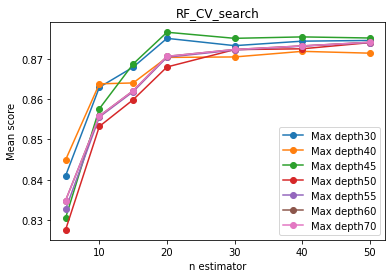

In [40]:
class_plot(grid_rf_1, grid_1, 'RF_CV_search')

In [41]:
print (grid_rf_1.best_params_)
print (grid_rf_1.best_score_)

{'max_depth': 45, 'n_estimators': 20}
0.8766940806782397


In [42]:
# re-train the model with full training set
rf_best = grid_rf_1.best_estimator_
rf_best.fit(co_combine_2_train_X, co_combine_2_train_y)
pred_rf_test = rf_best.predict(co_combine_2_test_X)

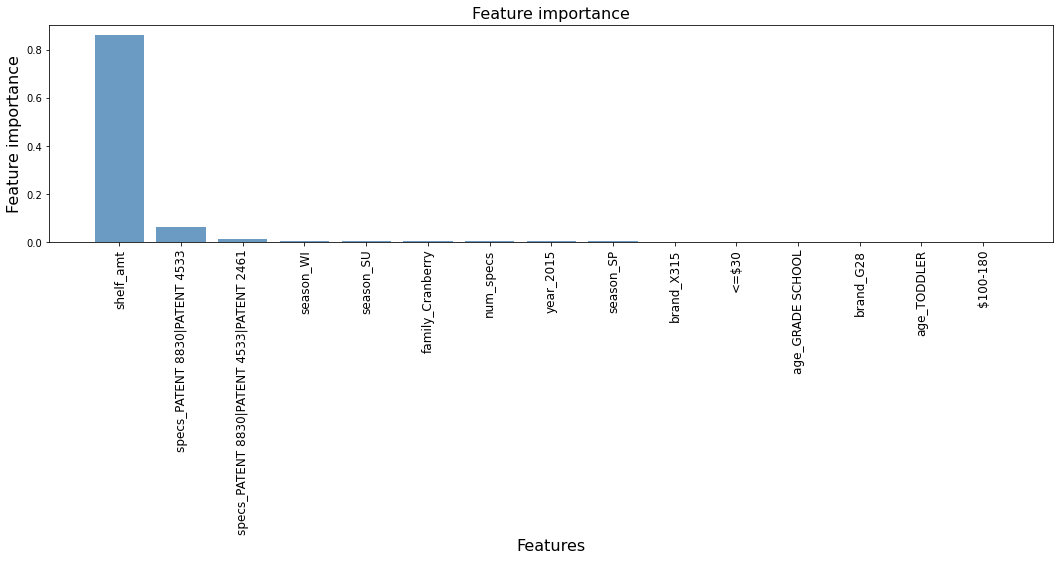

In [43]:
importance_rf_best = rf_best.feature_importances_
names_rf_best = co_combine_2_train_X.columns.tolist()
df_importantce_rf_best = pd.DataFrame({'Feature':names_rf_best, 'Importance':importance_rf_best})
# plot feature importance
rank_importance_rf_best = df_importantce_rf_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_rf_best,15, 'steelblue', 0.8, 18, 4, 'Feature importance')

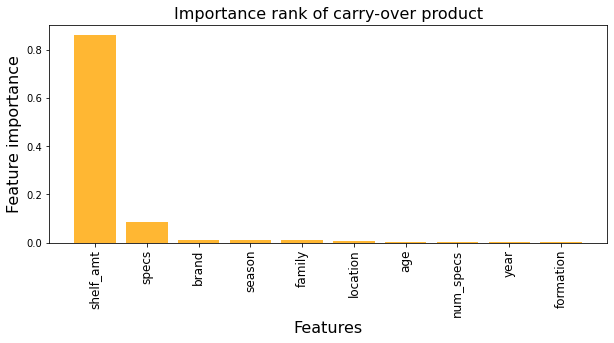

In [44]:
# plot feature importance ranking of original feature (before dummies)
raw_feature_importances_rf_best = raw_feature_importance(df_importantce_rf_best,2,cate_list)

plot_feature_importance(raw_feature_importances_rf_best, 21, 'orange', 0.8, 10, 4, 
                        'Importance rank of carry-over product')

In [45]:
# compare the aggreated prediction with actual sales
co_test_rf = co_combine_2_test.copy(deep=True)
co_test_rf['pred'] = np.round(pred_rf_test)
co_test_rf['pred'] = co_test_rf['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
co_test_rf_agg = co_test_rf.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

In [46]:
evaluate(co_test_rf_agg)

MAPE of prediction in SP2016 is 98.90569135839269
MAE of prediction in SP2016 is 8696.15987460815
MAD ratio of prediction in SP2016 is 0.9629398192579128


No handles with labels found to put in legend.


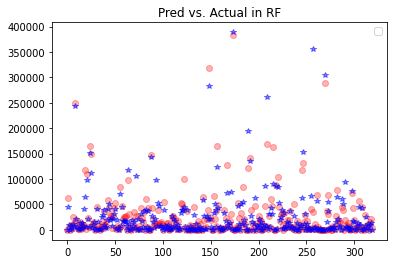

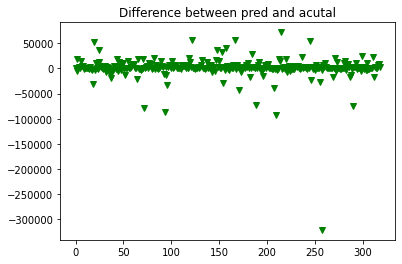

In [47]:
plot_diff(co_test_rf_agg, 'Pred vs. Actual in RF', 'Difference between pred and acutal')

In [48]:
# re-train with training+test data, save model for future prediction
co_combine_3 = co_combine_2.copy(deep =True)
co_combine_3 = shuffle(co_combine_3)
co_combine_3_X = co_combine_3.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_3_y = co_combine_3['sales_amt'] 

rf_best_co_model = rf_best.fit(co_combine_3_X,co_combine_3_y)

# save model
#joblib.dump(rf_best, 'rf_best_co.sav', compress=3)

## 4.2 New product model
* The product is new and has not been sold before.
* Find a group of old products similiar to the new product, train a model on them, and use this model for prediction
* Clustering could be another method, number of clusters can be a hyper-parameter

### 4.2.1 Similar product search¶
* Analyze the cosine similarity bewteen 87 new products in *new_product_1* and 320 products in *co_combine_1* with full historical data
* For each new product, the top 3 most similar old products are chosen
* Then use the data of these chosen carry-over products to train a model, which can predict demand of new products

In [49]:
similarity_prod = co_combine_1[['sku','brand','age','formation','family',
                                'specs','num_specs','<=$30','$30-60',
                                '$60-80','$80-100','$100-180','>$180']]

cate_similarity = ['brand','age','formation','family','specs']
                   
similarity_prod_dummy = pd.get_dummies(similarity_prod,columns=cate_similarity,
                                       drop_first=True) 

# get unique rows for cosine similarity compare
similarity_prod_dummy.drop_duplicates(inplace = True)

# this is is later ID mapping
prod_ID = similarity_prod_dummy['sku']

s_list = similarity_prod_dummy.drop(['sku'],axis=1).values.tolist()
# to operate cosine similarity



In [50]:
new_prod_dummy = pd.get_dummies(new_product_1,columns=cate_similarity,
                                       drop_first=True) 

In [51]:
# make the same column in whole data and new product data
diff_sim = list((set(new_prod_dummy.columns) -set(similarity_prod_dummy.columns)))
if len(diff_sim)!=0:
    new_prod_dummy.drop(diff_sim, axis = 1, inplace =True)

missing_cols_sim = set(similarity_prod_dummy.columns) - set(new_prod_dummy.columns)
# Add a missing column in test set with default value equal to 0
for m in missing_cols_sim:
    new_prod_dummy[m] = 0
    
new_prod_dummy = new_prod_dummy[similarity_prod_dummy.columns]

# get unique rows for cosine similarity compare
new_prod_dummy.drop_duplicates(inplace = True)
new_prod_ID = new_prod_dummy['sku']

s_new = new_prod_dummy.drop(['sku'], axis=1)
s_new_list = s_new.values.tolist()

In [52]:
# a special dict to have list as key, to keep order
# get the similarity between 87 new products and 320 carry-over products
d_sim = defaultdict(list)

for i in range(len(new_prod_ID)):
    for j in range(len(prod_ID)):
        s_new_list[i] = np.array(s_new_list[i]).reshape(1,-1)
        s_list[j] = np.array(s_list[j]).reshape(1,-1)
        tmp_sim = float(cosine_similarity(s_new_list[i],s_list[j]))
        d_sim[i].append(tmp_sim)

In [53]:
len(d_sim)

87

In [54]:
# get the top 3 most similar products list with each new product
high_sim_prod_index = set()
for ID in range(87):
    tmp_3 = sorted(range(320), key=lambda i: d_sim[ID][i])[-3:]
    for p in tmp_3:
        high_sim_prod_index.add(p)
        
high_sim_prod_ID = prod_ID.iloc[list(high_sim_prod_index)]
# high_sim_prod_ID.tolist()

### 4.2.2 Training/testing data for new product

In [55]:
similar_new_1 = co_combine_1[co_combine_1['sku'].isin(high_sim_prod_ID)]
print (similar_new_1.shape)
similar_new_2 = pd.get_dummies(similar_new_1,columns=cate_list,drop_first=True) 

(4141, 19)


In [56]:
# select ~20% latest data for test purpose
similar_new_2_test = similar_new_2[similar_new_2['quarter'] =='SP2016']
similar_new_2_train = similar_new_2[similar_new_2['quarter'] !='SP2016']

# prepare training and test data
similar_new_2_train = shuffle(similar_new_2_train)
similar_new_2_train_X = similar_new_2_train.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_train_y = similar_new_2_train['sales_amt'] 

similar_new_2_test_X = similar_new_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_test_y = similar_new_2_test['sales_amt'] 

### 4.2.3 Random forest model

In [57]:
grid_2 = {'n_estimators': [15,20,30,40,50,60,70,80],
          'max_depth': [5,10,20,30,40,50]}

rf_2 = RandomForestRegressor(random_state=2019, verbose=0,n_jobs =6)
grid_rf_2 = GridSearchCV(rf_2, grid_2, cv=3)
grid_rf_2.fit(similar_new_2_train_X, similar_new_2_train_y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=6, random_state=2019),
             param_grid={'max_depth': [5, 10, 20, 30, 40, 50],
                         'n_estimators': [15, 20, 30, 40, 50, 60, 70, 80]})

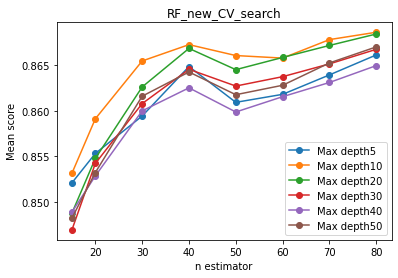

{'max_depth': 10, 'n_estimators': 80}
0.8686439273362381


In [58]:
class_plot(grid_rf_2, grid_2, 'RF_new_CV_search')
print (grid_rf_2.best_params_)
print (grid_rf_2.best_score_)

In [59]:
# re-train the model with full training set
rf_best_new = grid_rf_2.best_estimator_
rf_best_new.fit(similar_new_2_train_X, similar_new_2_train_y)
# save model
joblib.dump(rf_best_new, 'rf_best_new.sav', compress=3)

pred_rf_test_new = rf_best_new.predict(similar_new_2_test_X)

# compare the aggreated prediction with actual sales
new_test_rf = similar_new_2_test.copy(deep=True)
new_test_rf['pred'] = np.round(pred_rf_test_new)
new_test_rf['pred'] = new_test_rf['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
new_test_rf_agg = new_test_rf.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

In [60]:
evaluate(new_test_rf_agg)

MAPE of prediction in SP2016 is 206.5492958334563
MAE of prediction in SP2016 is 9944.805714285714
MAD ratio of prediction in SP2016 is 0.9505978427082891


No handles with labels found to put in legend.


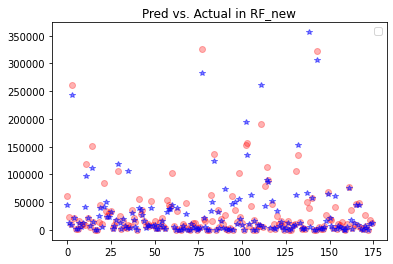

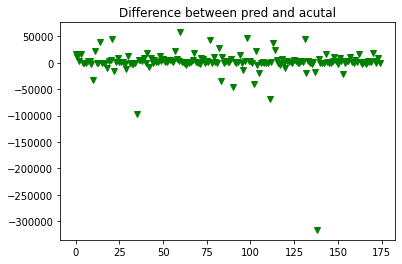

In [61]:
plot_diff(new_test_rf_agg, 'Pred vs. Actual in RF_new', 'Difference between pred and acutal')

In [62]:
# re-train with training+test data, save model for future prediction
similar_new_3 = similar_new_2.copy(deep =True)
similar_new_3= shuffle(similar_new_3)
similar_new_3_X = similar_new_3.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_3_y = similar_new_3['sales_amt'] 

rf_best_new_combine_model = rf_best_new.fit(similar_new_3_X,similar_new_3_y)

# save model
#joblib.dump(rf_best_new, 'rf_best_new_combine.sav', compress=3)

# 5.Prediction
* Use carry-over model and new-product model for carry-over and new products respectively
* Pre-process the input data so that they have the same columns as the data used to train the model


In [63]:
pred_test_co = rf_best_co_model.predict(co_combine_3_X)
pred_test_new = rf_best_new_combine_model.predict(similar_new_3_X)